In [53]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-2 region. You will use the 825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [106]:
bucket_name = 'diabetis' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')

In [55]:
#Loading Dataset

In [101]:
pwd

'/home/ec2-user/SageMaker'

In [105]:

try:
  model_data = pd.read_csv('s3://diabetis/datasets_228_482_diabetes.csv',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [107]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [108]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [109]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [110]:
data.dtypes

Pregnancies                    int64
Glucose                        int64
BloodPressure                  int64
SkinThickness                  int64
Insulin                        int64
BMI                          float64
DiabetesPedigreeFunction     float64
Age                            int64
Outcome                     category
dtype: object

In [111]:
data.nunique()<10

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                      True
dtype: bool

In [112]:
data['Outcome']=data['Outcome'].astype('category')

In [113]:
data.dtypes

Pregnancies                    int64
Glucose                        int64
BloodPressure                  int64
SkinThickness                  int64
Insulin                        int64
BMI                          float64
DiabetesPedigreeFunction     float64
Age                            int64
Outcome                     category
dtype: object

In [114]:
for col in data.columns:
    print(data[col].describe())

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64
count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64
count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64
count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64
count    768.000000
mean      31.9

In [115]:
#Exploratory Data Analysis

In [116]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [117]:
#Influence of Age factor
Data=data.copy()
Data['Age_Group'] = pd.cut(data['Age'], bins=[0,18,30,50,85],precision=0).astype('str')
print(Data['Age_Group'].unique())

['(30, 50]' '(18, 30]' '(50, 85]']


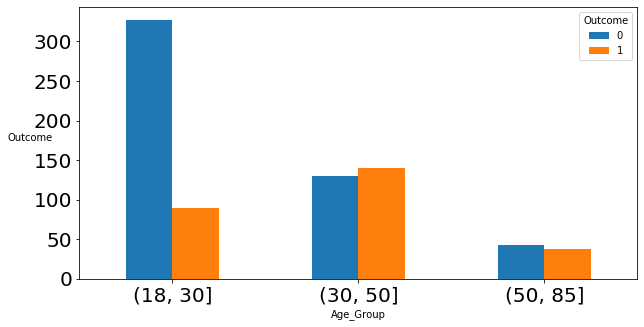

In [118]:
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
df1=pd.crosstab(Data['Age_Group'],Data['Outcome'])
pd.crosstab(Data['Age_Group'],Data['Outcome']).plot(kind='bar',figsize=(10,5),fontsize=20)
plt.xlabel('Age_Group',fontsize=10,rotation=0)
plt.ylabel('Outcome',fontsize=10,rotation=0)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()
#Comparitively women in the age group of 30-50 are prone to diabetis

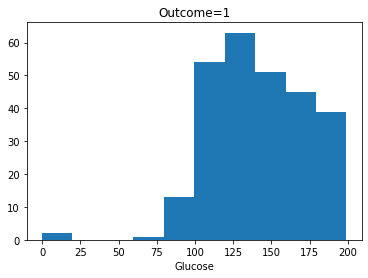

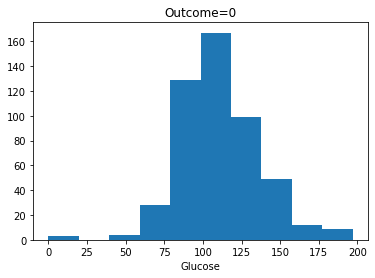

In [119]:
plt.hist(Data.loc[Data['Outcome']==1,:]['Glucose'])
plt.title("Outcome=1")
plt.xlabel("Glucose")
plt.show()
plt.close()
plt.hist(Data.loc[Data['Outcome']==0,:]['Glucose'])
plt.title("Outcome=0")
plt.xlabel("Glucose")
plt.show()
plt.close()

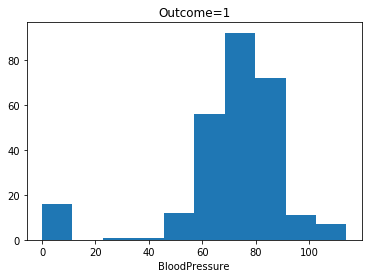

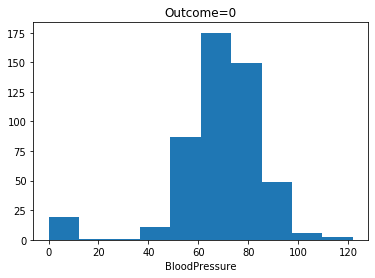

In [120]:
plt.hist(Data.loc[Data['Outcome']==1,:]['BloodPressure'])
plt.title("Outcome=1")
plt.xlabel("BloodPressure")
plt.show()
plt.close()
plt.hist(Data.loc[Data['Outcome']==0,:]['BloodPressure'])
plt.title("Outcome=0")
plt.xlabel("BloodPressure")
plt.show()
plt.close()

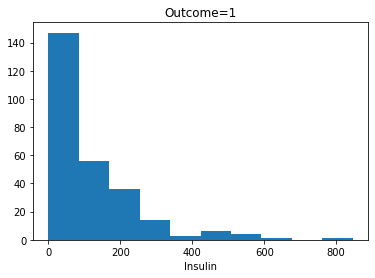

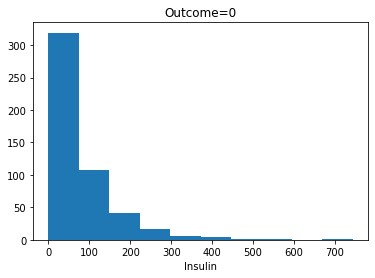

In [121]:
plt.hist(Data.loc[Data['Outcome']==1,:]['Insulin'])
plt.title("Outcome=1")
plt.xlabel("Insulin")
plt.show()
plt.close()
plt.hist(Data.loc[Data['Outcome']==0,:]['Insulin'])
plt.title("Outcome=0")
plt.xlabel("Insulin")
plt.show()
plt.close()

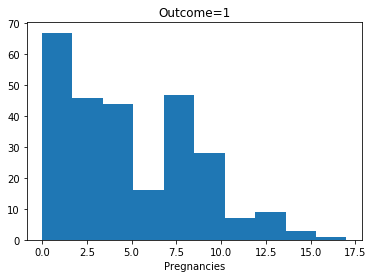

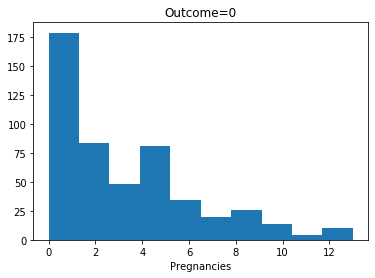

In [122]:
plt.hist(Data.loc[Data['Outcome']==1,:]['Pregnancies'])
plt.title("Outcome=1")
plt.xlabel("Pregnancies")
plt.show()
plt.close()
plt.hist(Data.loc[Data['Outcome']==0,:]['Pregnancies'])
plt.title("Outcome=0")
plt.xlabel("Pregnancies")
plt.show()
plt.close()

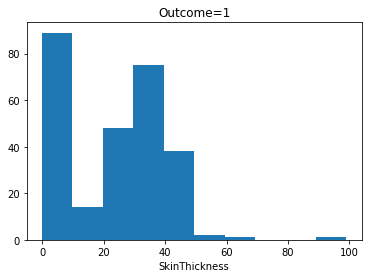

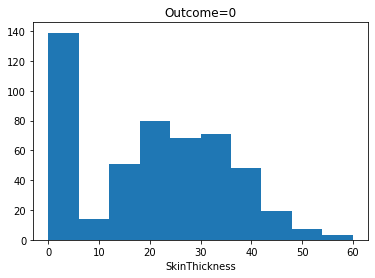

In [123]:
plt.hist(Data.loc[Data['Outcome']==1,:]['SkinThickness'])
plt.title("Outcome=1")
plt.xlabel("SkinThickness")
plt.show()
plt.close()
plt.hist(Data.loc[Data['Outcome']==0,:]['SkinThickness'])
plt.title("Outcome=0")
plt.xlabel("SkinThickness")
plt.show()
plt.close()

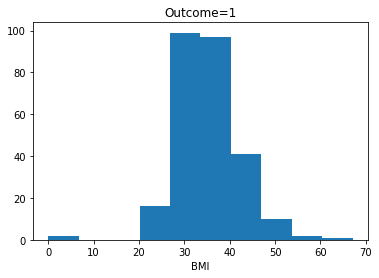

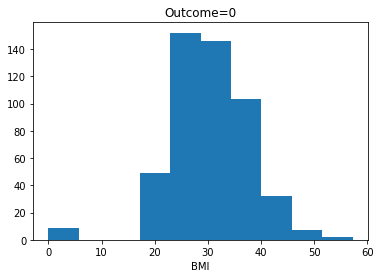

In [124]:
plt.hist(Data.loc[Data['Outcome']==1,:]['BMI'])
plt.title("Outcome=1")
plt.xlabel("BMI")
plt.show()
plt.close()
plt.hist(Data.loc[Data['Outcome']==0,:]['BMI'])
plt.title("Outcome=0")
plt.xlabel("BMI")
plt.show()
plt.close()

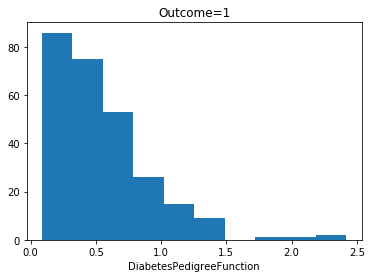

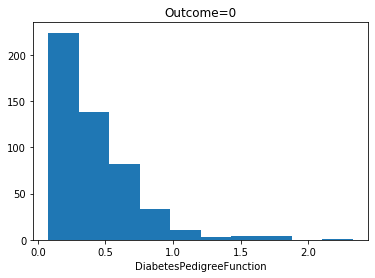

In [125]:
plt.hist(Data.loc[Data['Outcome']==1,:]['DiabetesPedigreeFunction'])
plt.title("Outcome=1")
plt.xlabel("DiabetesPedigreeFunction")
plt.show()
plt.close()
plt.hist(Data.loc[Data['Outcome']==0,:]['DiabetesPedigreeFunction'])
plt.title("Outcome=0")
plt.xlabel("DiabetesPedigreeFunction")
plt.show()
plt.close()

In [126]:
#Model Building

In [127]:
ins=[]
for col in data.columns:
  if col!='Outcome':
    ins.append(col)
print(ins)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [128]:
x=data[ins]
y=data['Outcome']

In [129]:
train_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data))])
print(train_data.shape, test_data.shape)

(537, 9) (231, 9)


In [130]:
train_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
536,0,105,90,0,0,29.6,0.197,46,0
408,8,197,74,0,0,25.9,1.191,39,1
117,5,78,48,0,0,33.7,0.654,25,0
286,5,155,84,44,545,38.7,0.619,34,0
96,2,92,62,28,0,31.6,0.130,24,0
...,...,...,...,...,...,...,...,...,...
434,1,90,68,8,0,24.5,1.138,36,0
634,10,92,62,0,0,25.9,0.167,31,0
578,10,133,68,0,0,27.0,0.245,36,0
335,0,165,76,43,255,47.9,0.259,26,0


In [131]:
pd.concat([train_data['Outcome'], train_data.drop(['Outcome'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [132]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
xgb = sagemaker.estimator.Estimator(containers[my_region],role, train_instance_count=1, train_instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [133]:
xgb

In [134]:
#Training the model

In [135]:
xgb.fit({'train': s3_input_train})

2020-09-18 12:03:54 Starting - Starting the training job...
2020-09-18 12:03:56 Starting - Launching requested ML instances......
2020-09-18 12:05:04 Starting - Preparing the instances for training.........
2020-09-18 12:06:49 Downloading - Downloading input data
2020-09-18 12:06:49 Training - Downloading the training image...
2020-09-18 12:07:10 Training - Training image download completed. Training in progress.Arguments: train
[2020-09-18:12:07:11:INFO] Running standalone xgboost training.
[2020-09-18:12:07:11:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-09-18:12:07:11:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8485.19mb
[2020-09-18:12:07:11:INFO] Determined delimiter of CSV input is ','
[12:07:11] S3DistributionType set as FullyReplicated
[12:07:11] 537x8 matrix with 4296 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[12:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

In [136]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [137]:
#prediction

In [138]:
test_data_array = test_data.drop(['Outcome'], axis=1).values #load the data into an array
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(231,)


In [139]:
cm = pd.crosstab(index=test_data['Outcome'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "NO", "YES"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 74.0%

Predicted      NO                  YES
Observed
No Purchase    76% (130)    32% (19)
Purchase        24% (41)     68% (41) 



In [140]:
print(cm)

Predicted  0.0  1.0
Observed           
0          130   19
1           41   41


In [141]:
xgb_predictor.endpoint

'xgboost-2020-09-18-12-03-54-732'